# Group 9

Benedikt Krupp (Sirati),
Matsuo Takumi, 
Bi Jing,
Eguchi Aoi 


# Breast cancer problem

## Import packages and read data

In [22]:
import numpy as np
import pandas as pd

from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import matplotlib.pyplot as plt
import csv

In [23]:
# Read data
path = './breast-cancer.data'
data = []; index = 0
with open(path) as f:
    print(type(f))
    s = f.read().split('\n')

input_data = []
index = 0
for ss in s:
    input_data.append(ss.split(','))
    index += 1

input_data.pop()

<class '_io.TextIOWrapper'>


['']

In [24]:
# Convert variables into integers
label = ['no-recurrence-events','recurrence-events']
age = ['10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-99']
menopause  = ['lt40', 'ge40', 'premeno']
tumor_size = ['0-4', '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59']
inv_nodes = ['0-2', '3-5', '6-8', '9-11', '12-14', '15-17', '18-20', '21-23', '24-26', '27-29', '30-32', '33-35', '36-39']
node_caps = ['yes','no','?']
deg_malig = ['1', '2', '3']
breast =  ['left', 'right']
breast_quad = ['left_up', 'left_low', 'right_up', 'right_low', 'central','?']
irradiat = ['yes', 'no']
parameters = [age, menopause, tumor_size, inv_nodes, node_caps, deg_malig, breast, breast_quad, irradiat]
parameter_names =  ['age', 'menopause', 'tumor_size', 'inv_nodes', 'node_caps', 'deg_malig', 'breast', 'breast_quad', 'irradiat']

def ConvertData(input_data):
    event = []
    for d in input_data:
        # class 
        if d[0] == label[0]:
            event.append(1)
        elif d[0] == label[1]:
            event.append(-1)
        # parameters
        for p_index, parameter in enumerate(parameters,1):
            found = False
            for index, p in enumerate(parameter):
                if d[p_index] == p:
                    event.append(index)
                    found = True
                    break
    
    return event

conv_data = ConvertData(input_data)
data_array = np.array( conv_data )
data = data_array.reshape((int)(len(data_array)/10),10)

In [25]:
# Split whole data set into train/test data set
label = data[:,0:1]
features = preprocessing.minmax_scale(data[:,1:]) 
train_data, test_data, train_label, test_label = train_test_split(features, label.ravel(), test_size=0.3) 
print("# of train sample : " , len(train_data))
print("# of test sample  : " , len(test_data))

# of train sample :  200
# of test sample  :  86


## Classical approach (SVM)

In [26]:
#model = svm.SVC(kernel='rbf', gamma=100, C=100)
model = svm.SVC(kernel='linear', gamma=1, C=10)
model.fit(train_data, train_label)

test_pred = model.predict(test_data)

from sklearn.metrics import accuracy_score, precision_score, recall_score
print("Accuracy score : ", accuracy_score(test_label, test_pred)) 
print("Precision score : ", precision_score(test_label, test_pred))
print("Recall score      : ", recall_score(test_label, test_pred))

Accuracy score :  0.7325581395348837
Precision score :  0.7407407407407407
Recall score      :  0.967741935483871


## Run on qiskit (QSVM)

In [27]:
#run on qiskit
import numpy as np
import matplotlib.pyplot as plt
import functools

from qiskit import BasicAer
from qiskit.circuit.library import ZFeatureMap,ZZFeatureMap, PauliFeatureMap
from qiskit.aqua import QuantumInstance
from qiskit.aqua.components.feature_maps import self_product
from qiskit.aqua.algorithms import QSVM
from qiskit.ml.datasets import ad_hoc_data, breast_cancer
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name
# setup aqua logging
import logging
from qiskit.aqua import set_qiskit_aqua_logging
# set_qiskit_aqua_logging(logging.DEBUG)  # choose INFO, DEBUG to see the log

%matplotlib inline

In [28]:
training_dataset = {'1': train_data[train_label==1], '0':train_data[train_label==-1]}
test_dataset = {'1': test_data[test_label==1], '0':test_data[test_label==-1]}

In [29]:
feature_dim = 9
# Using the statevector simulator
backend = BasicAer.get_backend('statevector_simulator')
random_seed = 10598

quantum_instance = QuantumInstance(backend, seed_simulator=random_seed, seed_transpiler=random_seed)

### 9-dimensional date take long time to process

In [9]:
# Generate the feature map
feature_map = ZFeatureMap(feature_dimension=feature_dim, reps=2)

# Run the Quantum Kernel Estimator and classify the test data
qsvm = QSVM(feature_map=feature_map, training_dataset=training_dataset, test_dataset=test_dataset)

result = qsvm.run(quantum_instance)
print("testing success ratio: ", result['testing_accuracy'])

testing success ratio:  0.686046511627907


### & too low!!!

## Plot data into 3-dim phase space

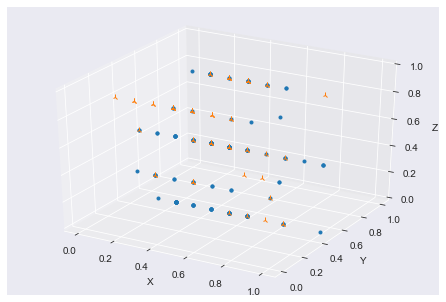

In [30]:

X = train_data[:,2]; Y = train_data[:,4]; Z = train_data[:,5]; L = train_label[:]

import seaborn as sns
sns.set_style("darkgrid")

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")

ax.plot(X[L==1],Y[L==1],Z[L==1],marker=".",linestyle='None')
ax.plot(X[L==-1],Y[L==-1],Z[L==-1],marker="2",linestyle='None')
plt.show()

In [31]:
# Save data as a dat file
with open('./all_data.dat','w') as f:
    for i in data:
        for j in i:
            f.write(str(j))
            f.write('    ')
        f.write('\n')
f.close()

## Data compression (PCA)

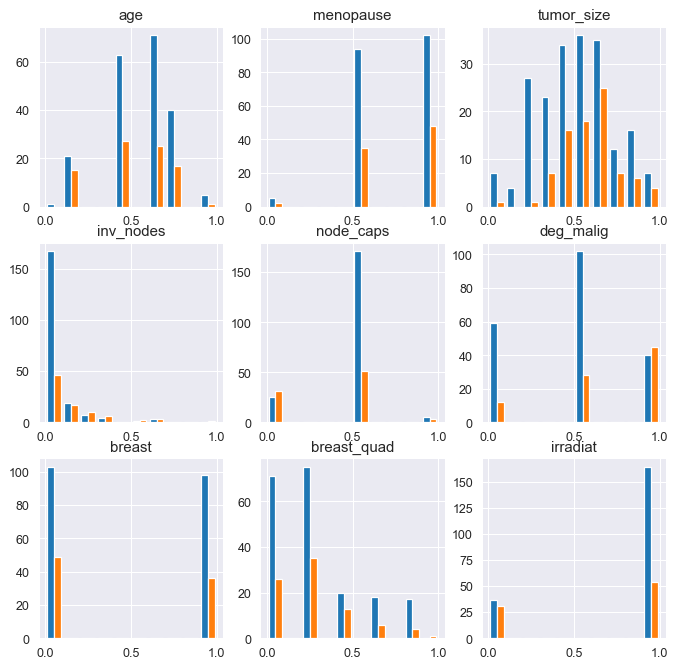

In [32]:
# Original data
fig = plt.figure(figsize=(9,9),dpi=90)
y= label[:,0]
for i in range(0,9):
    plt.subplot(3,3,i+1)
    plt.title(parameter_names[i])
    f = features[:,i]
    plt.hist([f[y==1], f[y==-1]], stacked=False)

In [33]:
X_train_scaled = pd.DataFrame(train_data)
X_test_scaled = pd.DataFrame(test_data)

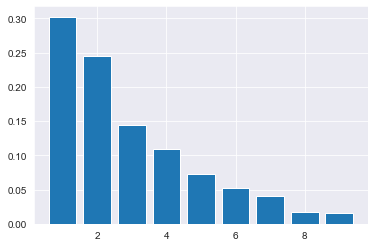

In [34]:
from sklearn.decomposition import PCA
pca = PCA(n_components=9)
pca.fit(X_train_scaled)
plt.bar([n for n in range(1, len(pca.explained_variance_ratio_)+1)], pca.explained_variance_ratio_)
plt.show()

X_train_pca shape: (200, 2)
explained variance ratio: [0.3354766  0.21012949]


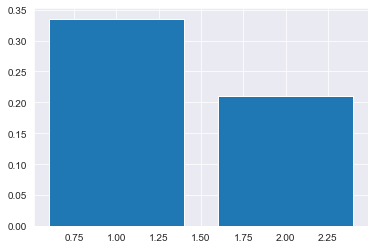

In [35]:
# Compresss data into 2-dim by using PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.fit_transform(X_test_scaled)
print('X_train_pca shape: {}'.format(X_train_pca.shape))

# Explainde variance ratio
print('explained variance ratio: {}'.format(pca.explained_variance_ratio_))

plt.bar([n for n in range(1, len(pca.explained_variance_ratio_)+1)], pca.explained_variance_ratio_)
plt.show()

In [36]:
feature_dim = 2 
training_dataset_size = 20
testing_dataset_size = 10
random_seed = 10598
shots = 1024

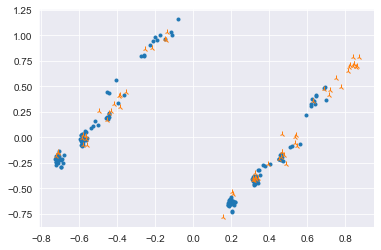

In [37]:
#plot
X = X_train_pca[:,0]; Y = X_train_pca[:,1]; L = train_label[:]

import seaborn as sns
sns.set_style("darkgrid")

plt.plot(X[L==1],Y[L==1],marker=".",linestyle='None')
plt.plot(X[L==-1],Y[L==-1],marker="2",linestyle='None')
plt.show()


In [38]:

#model = svm.SVC(kernel='rbf', gamma=100, C=100)
model = svm.SVC(kernel='linear', gamma=1, C=10)
model.fit(X_train_pca, train_label)

test_pred = model.predict(X_test_pca)

from sklearn.metrics import accuracy_score, precision_score, recall_score
print("Accuracy score : ", accuracy_score(test_label, test_pred)) 
print("Precision score : ", precision_score(test_label, test_pred))
print("Recall score      : ", recall_score(test_label, test_pred))

Accuracy score :  0.7209302325581395
Precision score :  0.7209302325581395
Recall score      :  1.0


### Scores are slightly lower, but this will save us a lot of time

## Approach on qiskit

### First order diagonal expansion

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import functools

from qiskit import BasicAer
from qiskit.circuit.library import ZFeatureMap,ZZFeatureMap, PauliFeatureMap
from qiskit.aqua import QuantumInstance
from qiskit.aqua.components.feature_maps import self_product
from qiskit.aqua.algorithms import QSVM
from qiskit.ml.datasets import ad_hoc_data, breast_cancer
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name
# setup aqua logging
import logging
from qiskit.aqua import set_qiskit_aqua_logging
# set_qiskit_aqua_logging(logging.DEBUG)  # choose INFO, DEBUG to see the log

%matplotlib inline

In [40]:
training_dataset = {'1': X_train_pca[train_label==1], '0':X_train_pca[train_label==-1]}
test_dataset = {'1': X_test_pca[test_label==1], '0':X_test_pca[test_label==-1]}

In [41]:
feature_dim = 2
# Using the statevector simulator
backend = BasicAer.get_backend('statevector_simulator')
random_seed = 10598

quantum_instance = QuantumInstance(backend, seed_simulator=random_seed, seed_transpiler=random_seed)

In [88]:
# Generate the feature map
feature_map = ZFeatureMap(feature_dimension=feature_dim, reps=2)

# Run the Quantum Kernel Estimator and classify the test data
qsvm = QSVM(feature_map=feature_map, training_dataset=training_dataset, test_dataset=test_dataset)

result = qsvm.run(quantum_instance)
print("testing success ratio: ", result['testing_accuracy'])

testing success ratio:  0.7325581395348837


### Second order diagonal expansion

In [89]:
# training_dataset = {'A': train_data[train_label==1], 'B':train_data[train_label==-1]}
# test_dataset = {'A': test_data[test_label==1], 'B':test_data[test_label==-1]}

In [42]:
feature_dim = 2
shots = 1024
seed = 10598

datapoints, class_to_label = split_dataset_to_data_and_labels(test_dataset)

In [43]:
feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2, entanglement='linear')
qsvm = QSVM(feature_map, training_dataset, test_dataset, datapoints[0])

backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)



result = qsvm.run(quantum_instance)

print("testing success ratio: {}".format(result['testing_accuracy']))
print("preduction of datapoints:")
print("ground truth: {}".format(map_label_to_class_name(datapoints[1], qsvm.label_to_class)))
print("prediction:   {}".format(result['predicted_classes']))
     

BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

kernel matrix during the training:


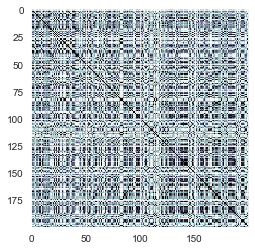

In [23]:
print("kernel matrix during the training:")
kernel_matrix = result['kernel_matrix_training']
img = plt.imshow(np.asmatrix(kernel_matrix),interpolation='nearest',origin='upper',cmap='bone_r')
plt.show()

## Variational Quantum Classifier (VQC)

In [24]:
from qiskit.aqua.algorithms import VQC
from qiskit.aqua.components.optimizers import SPSA
from qiskit.circuit.library import TwoLocal

In [27]:
backend = BasicAer.get_backend('qasm_simulator')
optimizer = SPSA(max_trials=100, c0=4.0, skip_calibration=True)
optimizer.set_options(save_steps=1)
feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2)
var_form = TwoLocal(feature_dim, ['ry', 'rz'], 'cz', reps=3)
vqc = VQC(optimizer, feature_map, var_form, training_dataset, test_dataset)
quantum_instance = QuantumInstance(backend, shots=shots, seed_simulator=random_seed, seed_transpiler=random_seed)

In [44]:
### collapse ###

result = vqc.run(quantum_instance)
print("testing success ratio: ", result['testing_accuracy'])

NameError: name 'vqc' is not defined

In [33]:
predicted_probs, predicted_labels = vqc.predict(datapoints[0])
predicted_classes = map_label_to_class_name(predicted_labels, vqc.label_to_class)
print("prediction:   {}".format(predicted_labels))

AquaError: 'Cannot find optimal params before running the algorithm.'